Skin cancer detection

In [168]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits, load_sample_images

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#%load_ext autoreload
#%autoreload 2

In [126]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=118)

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=2239)

# Get all the data in the directory data/validation (132 images), and reshape them
#val_generator = ImageDataGenerator().flow_from_directory(
#        val_data_dir, classes=['test'])

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
#val_images, val_labels = next(val_generator)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [128]:
train_images

array([[[[179., 140., 135.],
         [181., 143., 142.],
         [185., 146., 147.],
         ...,
         [189., 157., 160.],
         [187., 155., 160.],
         [185., 153., 158.]],

        [[178., 141., 135.],
         [181., 142., 143.],
         [185., 146., 147.],
         ...,
         [191., 159., 162.],
         [188., 157., 162.],
         [186., 154., 159.]],

        [[177., 140., 134.],
         [181., 144., 138.],
         [185., 147., 146.],
         ...,
         [191., 159., 162.],
         [191., 161., 163.],
         [188., 157., 162.]],

        ...,

        [[178., 138., 138.],
         [183., 143., 143.],
         [184., 146., 145.],
         ...,
         [195., 161., 162.],
         [195., 163., 164.],
         [192., 160., 161.]],

        [[179., 141., 140.],
         [183., 145., 144.],
         [185., 147., 146.],
         ...,
         [196., 160., 162.],
         [192., 160., 161.],
         [191., 161., 161.]],

        [[181., 143., 142.],
       

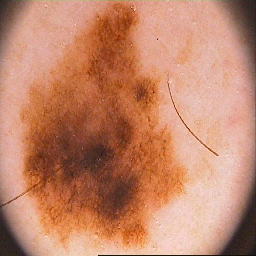

In [3]:
# Preview an image
array_to_img(train_images[0])

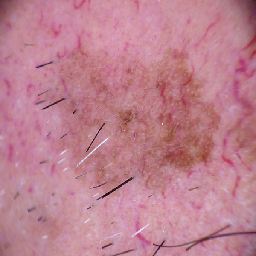

In [4]:
# Preview an image
array_to_img(test_images[0])

In [5]:
train_labels.shape

(2239, 9)

In [6]:
test_labels.shape

(118, 9)

In [7]:
test_images.shape

(118, 256, 256, 3)

In [8]:
train_images.shape

(2239, 256, 256, 3)

In [9]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
type(train_labels)

numpy.ndarray

In [11]:
type(train_images)

numpy.ndarray

In [12]:
dataframe=pd.DataFrame(train_labels, columns=['actinic_keratosis', 'basal_cell_carcinoma',\
            'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis',\
            'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion'])

In [13]:
dataframe

,actinic_keratosis,basal_cell_carcinoma,dermatofibroma,melanoma,nevus,pigmented_benign_keratosis,seborrheic_keratosis,squamous_cell_carcinoma,vascular_lesion
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2235,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2237,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#dataframe.hist()

In [15]:
sums=dataframe.sum(axis=0)

In [16]:
sums=pd.DataFrame(sums)

In [17]:
sums

,0
actinic_keratosis,114.0
basal_cell_carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented_benign_keratosis,462.0
seborrheic_keratosis,77.0
squamous_cell_carcinoma,181.0
vascular_lesion,139.0


In [18]:
sums['%'] = ((sums[0] / 2239*100).round(2).astype(str) + '%')

In [19]:
sums

,0,%
actinic_keratosis,114.0,5.09%
basal_cell_carcinoma,376.0,16.79%
dermatofibroma,95.0,4.24%
melanoma,438.0,19.56%
nevus,357.0,15.94%
pigmented_benign_keratosis,462.0,20.63%
seborrheic_keratosis,77.0,3.44%
squamous_cell_carcinoma,181.0,8.08%
vascular_lesion,139.0,6.21%


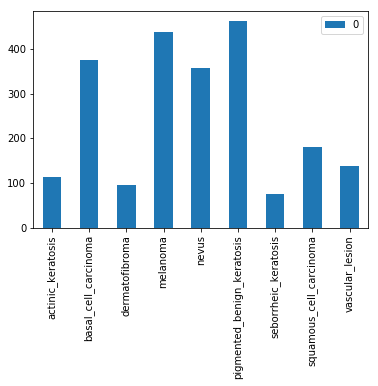

In [20]:
#Change this into seaborn to make it even cooler
sums.plot(kind='bar');

In [21]:
train_generator.class_indices 

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

Defining a function to visualize the results.

In [30]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

Look at lab on https://github.com/learn-co-curriculum/dsc-image-classification-with-mlps-lab/tree/solution
might need to do some one hot encoding.
Also, just like it shows there, as a naive model maybe decrease the number of layers and keep epochs at like 5.
If results are the same, try to understand why the loss still showes such high peaks.And why the accuracy drops like that.
Might also be worth doing CNN from the start with 2D layers instead of this basic NN.

Let us forget about all of this and try with the 2D actual convolutional neural network for images. The perfmormance there might be different.

We can also do something else which is group together the types of skin abnormalities that are cancerous and the ones that are not, reducing the classes to 2 and making this a binary classification problem.
I will do that later on. For now let's see what happens with a convolutional neural network, which is what I should be doing anyway.

Here also definitely preview one image per class and explain a bit about each class.

## Preprocessing

In [173]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(32, 32), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(32, 32), batch_size=2239)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [61]:
# Explore your dataset again
m_train = train_img.shape[0]
num_px = train_img.shape[1]
m_test = test_img.shape[0]
#m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
#print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_img.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img.shape))
print ("test_labels shape: " + str(test_lab.shape))
#print ("val_images shape: " + str(val_images.shape))
#print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 32, 32, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 32, 32, 3)
test_labels shape: (118, 9)


In [138]:
train_lab.shape[0]

2239

In [62]:
#train_img = train_img.reshape(train_img.shape[0], -1)
#test_img = test_img.reshape(test_img.shape[0], -1)
#val_img = val_images.reshape(val_images.shape[0], -1)

#print(val_img.shape)

(2239, 32, 32, 3)
(118, 32, 32, 3)


As we can see the RGB values of each pixel are not scaled, we are going to scale their value between 0 and 1 by dividing each pixel value by 225,
and we are also going to reshape the data in a format that can be fed into the model.
We are going to put these two preprocessing steps together with a pipeline.

#### Here I am going to create my first pipeline 
to use to scale and reshape the data once I have loaded it
Or possibly even a function to load it.

to standardize the pixel values:

In [175]:
def scale_pixels(train_img, test_img):
    train_img /= 255.
    test_img /= 255.
    return train_img, test_img

In [176]:
# Instantiate transformer
pix_scaler = FunctionTransformer(scale_pixels)

In [194]:
pix_scaler.fit(train_img, test_img)

FunctionTransformer(func=<function scale_pixels at 0x7f8fbe5c99d8>)

In [197]:
pix_scaler.predict(train_img, test_img)

AttributeError: 'FunctionTransformer' object has no attribute 'predict'

In [198]:
from sklearn.preprocessing import StandardScaler
StandardScaler().fit_transform(train_img)

ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [186]:
test_img.shape

(118, 32, 32, 3)

In [187]:
train_img.shape

(2239, 32, 32, 3)

In [137]:
# Instantiate StandardScaler
scaler = MinMaxScaler()
# Transform the training and test sets
#scaled_data_train = scaler.fit_transform(train_img)
#scaled_data_test = scaler.transform(test_img)

# Convert into a DataFrame
#scaled_df_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
#scaled_df_train.head()

In [165]:
#scale_pixels(train_img, test_img)

In [166]:
train_img

array([[[[2.9834679e-03, 1.8146867e-03, 2.4144561e-03],
         [3.0603614e-03, 1.9838526e-03, 2.5528644e-03],
         [3.0142253e-03, 2.1683970e-03, 2.5221070e-03],
         ...,
         [2.7681661e-03, 1.9223376e-03, 2.3990774e-03],
         [2.6758939e-03, 1.8608228e-03, 2.1376396e-03],
         [2.4605922e-03, 1.6301422e-03, 1.9992313e-03]],

        [[3.0757401e-03, 2.1991543e-03, 2.6912726e-03],
         [2.9527105e-03, 1.5532487e-03, 2.1837757e-03],
         [3.1218762e-03, 2.0915035e-03, 2.6297579e-03],
         ...,
         [2.5374857e-03, 1.4609765e-03, 1.8915802e-03],
         [2.6297579e-03, 1.7993080e-03, 2.1530183e-03],
         [2.5528644e-03, 1.7070358e-03, 1.9992313e-03]],

        [[2.9988466e-03, 2.1222609e-03, 2.6297579e-03],
         [3.2602844e-03, 2.3529413e-03, 2.7835448e-03],
         [3.0757401e-03, 2.1068822e-03, 2.5221070e-03],
         ...,
         [2.8911957e-03, 1.9992313e-03, 2.3375626e-03],
         [2.8450596e-03, 2.0607461e-03, 2.3529413e-03],
  

To change the shape of the labels:

In [144]:
print(train_lab.shape)
print(test_lab.shape)

(2239, 9)
(118, 9)


In [177]:
def reshape (train_lab, test_lab):
    m=train_lab.shape[0]
    n=test_lab.shape[0]
    train_lab = np.reshape(train_lab[:,0], (m,1))
    test_lab = np.reshape(test_lab[:,0], (n,1))
    return train_lab, test_lab

In [178]:
# Instantiate transformer
shaper = FunctionTransformer(reshape)

In [161]:
#train_y, test_y=reshape(train_lab, test_lab)

In [162]:
print(train_lab.shape)
print(test_lab.shape)

(2239, 9)
(118, 9)


In [148]:
#train_y = np.reshape(train_lab[:,0], (2239,1))
#test_y = np.reshape(test_lab[:,0], (118,1))

In [163]:
print(train_y.shape)
print(test_y.shape)

(2239, 1)
(118, 1)


In [179]:
# Build a pipeline with StandardScaler and KNeighborsClassifier
scale_pipeline = Pipeline([('pixel scaler', pix_scaler(train_img, test_img)),
        ('changing shape', shaper(train_lab, test_lab))])

TypeError: 'FunctionTransformer' object is not callable

In [180]:
scale_pipeline.fit(train_img, test_img, train_lab, test_lab)

TypeError: fit() takes from 2 to 3 positional arguments but 5 were given

In [67]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [68]:
#visualize_training_results(history)

Trying with a simple model:

In [134]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

And doing only 10 epochs:

In [70]:
history1 = model.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 3s 10ms/step - loss: 4.0951 - acc: 0.8947 - val_loss: 0.4263 - val_acc: 0.9449
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.4304 - acc: 0.9298 - val_loss: 0.4404 - val_acc: 0.9182
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.3108 - acc: 0.9381 - val_loss: 0.3596 - val_acc: 0.9241
Epoch 4/10
157/157 [==============================] - 1s 8ms/step - loss: 0.3530 - acc: 0.9445 - val_loss: 0.6524 - val_acc: 0.9494
Epoch 5/10
157/157 [==============================] - 1s 8ms/step - loss: 0.3148 - acc: 0.9521 - val_loss: 0.7317 - val_acc: 0.8929
Epoch 6/10
157/157 [==============================] - 1s 6ms/step - loss: 0.2748 - acc: 0.9509 - val_loss: 0.7142 - val_acc: 0.9405
Epoch 7/10
157/157 [==============================] - 1s 8ms/step - loss: 0.2207 - acc: 0.9579 - val_loss: 0.5259 - val_acc: 0.9315
Epoch 8/10
157/157 [==============================] - 1s 9ms/step - loss: 0

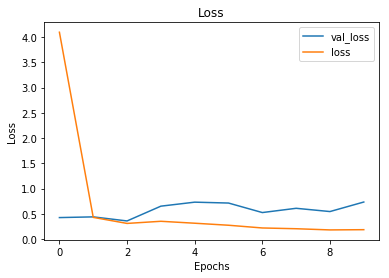

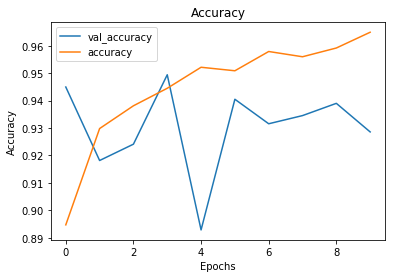

In [71]:
visualize_training_results(history1)

In [72]:
#history1.history['acc']

In [73]:
results=[]
results.append('32 bits first model')
results.append(['acc train',round(history1.history['acc'][-1],3)])
results.append(['acc valid',round(history1.history['val_acc'][-1],3)])
results.append(['loss train',round(history1.history['loss'][-1],3)])
results.append(['loss valid',round(history1.history['val_loss'][-1],3)])

In [74]:
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734]]

In [ ]:
# Build a pipeline with StandardScaler and KNeighborsClassifier
scaled_pipeline_1 = Pipeline([('ssc', StandardScaler()), ('KNN', KNeighborsClassifier())])

In [ ]:
# Fit the training data to pipeline
scaled_pipeline_1.fit(X_train, y_train)

# Print the accuracy on test set
scaled_pipeline_1.score(X_test, y_test)

Let me try with a larger batch size:

In [75]:
history2 = model.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 18ms/step - loss: 0.1726 - acc: 0.9620 - val_loss: 0.5758 - val_acc: 0.9219
Epoch 2/10
36/36 [==============================] - 1s 24ms/step - loss: 0.1494 - acc: 0.9598 - val_loss: 0.5772 - val_acc: 0.9263
Epoch 3/10
36/36 [==============================] - 1s 22ms/step - loss: 0.1298 - acc: 0.9671 - val_loss: 0.5506 - val_acc: 0.9286
Epoch 4/10
36/36 [==============================] - 1s 20ms/step - loss: 0.1353 - acc: 0.9637 - val_loss: 0.6172 - val_acc: 0.9196
Epoch 5/10
36/36 [==============================] - 1s 18ms/step - loss: 0.1008 - acc: 0.9654 - val_loss: 1.4593 - val_acc: 0.9442
Epoch 6/10
36/36 [==============================] - 1s 17ms/step - loss: 0.0989 - acc: 0.9637 - val_loss: 0.6508 - val_acc: 0.9263
Epoch 7/10
36/36 [==============================] - 1s 17ms/step - loss: 0.0914 - acc: 0.9721 - val_loss: 0.8512 - val_acc: 0.9062
Epoch 8/10
36/36 [==============================] - 1s 17ms/step - loss: 0.1120 - a

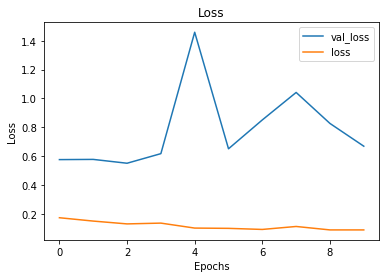

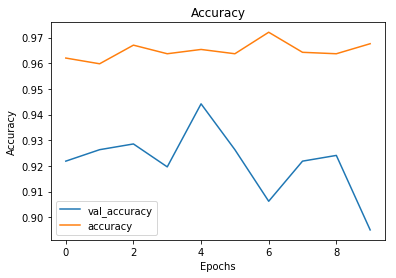

In [76]:
visualize_training_results(history2)

In [77]:
results.append('32 bits second model, larger batch')
results.append(['acc train',round(history2.history['acc'][-1],3)])
results.append(['acc valid',round(history2.history['val_acc'][-1],3)])
results.append(['loss train',round(history2.history['loss'][-1],3)])
results.append(['loss valid',round(history2.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669]]

Another attempt: all the previous parameters but making the last dense layer smaller.

In [78]:
model2 = models.Sequential()
model2.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dense(9, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [79]:
history3 = model2.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 26ms/step - loss: 4.5659 - acc: 0.9341 - val_loss: 0.3785 - val_acc: 0.9442
Epoch 2/10
36/36 [==============================] - 1s 17ms/step - loss: 0.2680 - acc: 0.9492 - val_loss: 0.2387 - val_acc: 0.9464
Epoch 3/10
36/36 [==============================] - 1s 16ms/step - loss: 0.2259 - acc: 0.9497 - val_loss: 0.2794 - val_acc: 0.9464
Epoch 4/10
36/36 [==============================] - 1s 16ms/step - loss: 0.2127 - acc: 0.9492 - val_loss: 0.4461 - val_acc: 0.9442
Epoch 5/10
36/36 [==============================] - 1s 15ms/step - loss: 0.5454 - acc: 0.9246 - val_loss: 0.2096 - val_acc: 0.9464
Epoch 6/10
36/36 [==============================] - 1s 17ms/step - loss: 0.1912 - acc: 0.9497 - val_loss: 0.2224 - val_acc: 0.9464
Epoch 7/10
36/36 [==============================] - 1s 20ms/step - loss: 0.1912 - acc: 0.9492 - val_loss: 0.2135 - val_acc: 0.9464
Epoch 8/10
36/36 [==============================] - 1s 16ms/step - loss: 0.2009 - a

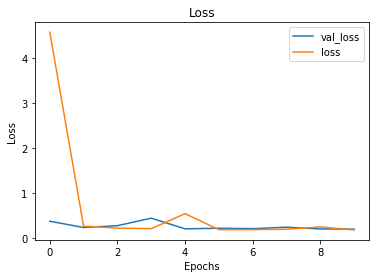

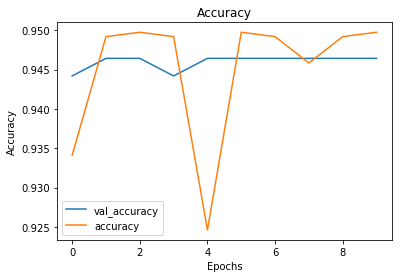

In [80]:
visualize_training_results(history3)

In [81]:
results.append('32 bits third model, less neurons in last layer')
results.append(['acc train',round(history3.history['acc'][-1],3)])
results.append(['acc valid',round(history3.history['val_acc'][-1],3)])
results.append(['loss train',round(history3.history['loss'][-1],3)])
results.append(['loss valid',round(history3.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204]]

Even less Neurons:

In [82]:
model3 = models.Sequential()
model3.add(layers.Conv2D(5, (3, 3), activation='relu',
                        input_shape=(32 ,32,  3)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dense(5, activation='relu'))
model3.add(layers.Dense(9, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [83]:
history4 = model3.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=50, validation_split=0.2)

Epoch 1/10
36/36 [==============================] - 1s 23ms/step - loss: 5.4090 - acc: 0.8973 - val_loss: 2.1186 - val_acc: 0.9420
Epoch 2/10
36/36 [==============================] - 1s 15ms/step - loss: 1.5177 - acc: 0.9497 - val_loss: 1.6335 - val_acc: 0.9464
Epoch 3/10
36/36 [==============================] - 1s 15ms/step - loss: 1.0580 - acc: 0.9486 - val_loss: 0.9751 - val_acc: 0.9442
Epoch 4/10
36/36 [==============================] - 1s 15ms/step - loss: 0.6867 - acc: 0.9492 - val_loss: 0.8203 - val_acc: 0.9442
Epoch 5/10
36/36 [==============================] - 1s 18ms/step - loss: 0.5767 - acc: 0.9497 - val_loss: 0.7716 - val_acc: 0.9442
Epoch 6/10
36/36 [==============================] - 1s 17ms/step - loss: 0.5398 - acc: 0.9492 - val_loss: 0.9107 - val_acc: 0.9464
Epoch 7/10
36/36 [==============================] - 1s 16ms/step - loss: 0.4651 - acc: 0.9497 - val_loss: 0.8025 - val_acc: 0.9464
Epoch 8/10
36/36 [==============================] - 1s 15ms/step - loss: 0.4140 - a

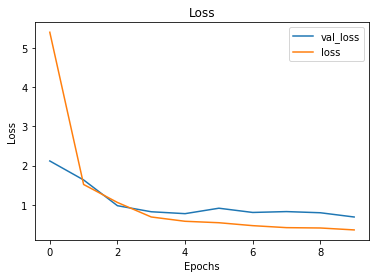

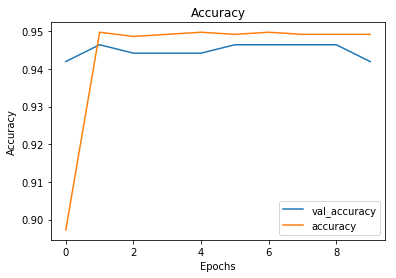

In [84]:
visualize_training_results(history4)

In [85]:
results.append('32 bits fourth model, less neurons overall')
results.append(['acc train',round(history4.history['acc'][-1],3)])
results.append(['acc valid',round(history4.history['val_acc'][-1],3)])
results.append(['loss train',round(history4.history['loss'][-1],3)])
results.append(['loss valid',round(history4.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686]]

#### No sorry one more thing. Even less resolution images.

In [86]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=2239)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [87]:
# Explore your dataset again
m_train = train_img.shape[0]
num_px = train_img.shape[1]
m_test = test_img.shape[0]
#m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
#print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_img.shape))
print ("train_labels shape: " + str(train_lab.shape))
print ("test_images shape: " + str(test_img.shape))
print ("test_labels shape: " + str(test_lab.shape))

Number of training samples: 2239
Number of testing samples: 118
train_images shape: (2239, 8, 8, 3)
train_labels shape: (2239, 9)
test_images shape: (118, 8, 8, 3)
test_labels shape: (118, 9)


In [88]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [89]:
model5 = models.Sequential()
model5.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(8 ,8,  3)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Flatten())
#model5.add(layers.Dense(3, activation='relu'))
model5.add(layers.Dense(9, activation='softmax'))

model5.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [90]:
history5 = model5.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 1s 4ms/step - loss: 44.4945 - acc: 0.7415 - val_loss: 2.1276 - val_acc: 0.9182
Epoch 2/10
157/157 [==============================] - 1s 4ms/step - loss: 1.3527 - acc: 0.8966 - val_loss: 1.2699 - val_acc: 0.8244
Epoch 3/10
157/157 [==============================] - 1s 4ms/step - loss: 0.8934 - acc: 0.9017 - val_loss: 0.8553 - val_acc: 0.9196
Epoch 4/10
157/157 [==============================] - 1s 4ms/step - loss: 0.7167 - acc: 0.9036 - val_loss: 0.8105 - val_acc: 0.9390
Epoch 5/10
157/157 [==============================] - 1s 4ms/step - loss: 0.5634 - acc: 0.9087 - val_loss: 0.6936 - val_acc: 0.8304
Epoch 6/10
157/157 [==============================] - 1s 4ms/step - loss: 0.4700 - acc: 0.9119 - val_loss: 0.4210 - val_acc: 0.8899
Epoch 7/10
157/157 [==============================] - 1s 4ms/step - loss: 0.3721 - acc: 0.9164 - val_loss: 0.4855 - val_acc: 0.9420
Epoch 8/10
157/157 [==============================] - 1s 4ms/step - loss: 0

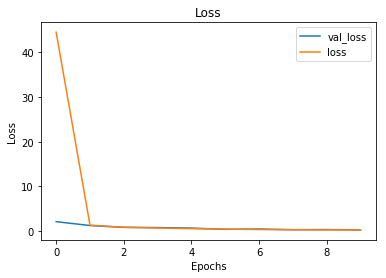

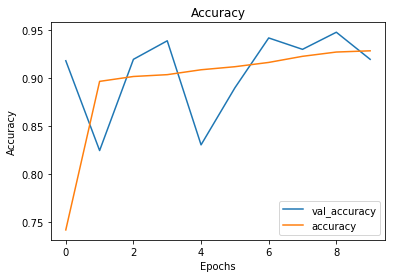

In [91]:
visualize_training_results(history5)

In [92]:
results.append('8 bits fifth model')
results.append(['acc train',round(history5.history['acc'][-1],3)])
results.append(['acc valid',round(history5.history['val_acc'][-1],3)])
results.append(['loss train',round(history5.history['loss'][-1],3)])
results.append(['loss valid',round(history5.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686],
 '8 bits fifth model',
 ['acc train', 0.929],
 ['acc valid', 0.92],
 ['loss train', 0.293],
 ['loss valid', 0.289]]

Let me try to decrease the batch size already from the import, see if is changes anything.

In [93]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(8, 8), batch_size=5)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(8, 8), batch_size=20)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [94]:
train_y = np.reshape(train_lab[:,0], (20,1))
test_y = np.reshape(test_lab[:,0], (5,1))

In [95]:
history6 = model5.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
2/2 [==============================] - 0s 53ms/step - loss: 0.6314 - acc: 0.9286 - val_loss: 0.3610 - val_acc: 0.8333
Epoch 2/10
2/2 [==============================] - 0s 35ms/step - loss: 0.3948 - acc: 0.9286 - val_loss: 0.3769 - val_acc: 0.6667
Epoch 3/10
2/2 [==============================] - 0s 59ms/step - loss: 0.2425 - acc: 0.8571 - val_loss: 0.3719 - val_acc: 0.6667
Epoch 4/10
2/2 [==============================] - 0s 35ms/step - loss: 0.1920 - acc: 0.8571 - val_loss: 0.3778 - val_acc: 0.8333
Epoch 5/10
2/2 [==============================] - 0s 33ms/step - loss: 0.0861 - acc: 1.0000 - val_loss: 0.3918 - val_acc: 0.8333
Epoch 6/10
2/2 [==============================] - 0s 37ms/step - loss: 0.0513 - acc: 1.0000 - val_loss: 0.4168 - val_acc: 0.8333
Epoch 7/10
2/2 [==============================] - 0s 41ms/step - loss: 0.0436 - acc: 1.0000 - val_loss: 0.4291 - val_acc: 0.8333
Epoch 8/10
2/2 [==============================] - 0s 35ms/step - loss: 0.0391 - acc: 1.0000 - val

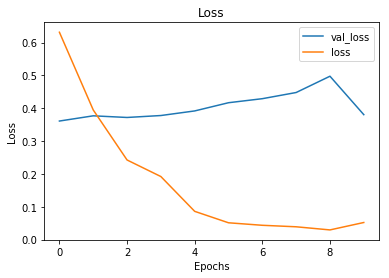

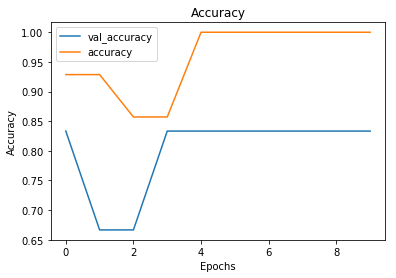

In [96]:
visualize_training_results(history6)

In [97]:
results.append('8 bits fifth model smaller batch on import')
results.append(['acc train',round(history6.history['acc'][-1],3)])
results.append(['acc valid',round(history6.history['val_acc'][-1],3)])
results.append(['loss train',round(history6.history['loss'][-1],3)])
results.append(['loss valid',round(history6.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686],
 '8 bits fifth model',
 ['acc train', 0.929],
 ['acc valid', 0.92],
 ['loss train', 0.293],
 ['loss valid', 0.289],
 '8 bits fifth model smaller batch on import',
 ['acc train', 1.0],
 ['acc valid', 0.833],
 ['loss train', 0.052],
 ['loss valid', 0.38]]

The good news is that even if the results change a lot in the first part where I do regualr NN, every time I run the code, they don't change so radically with the CNN.
I will keep track a bit but overall it seems like I can stop worrying about reproducibe results, if I use CNN right away.

## Starting to improve our model:

Taking from the german signs notebook

Nope. It's in AWS Sagemaker. But I can look back at it and use either a simple pipeline for loading and changing the size of the images, or for images augmentation to balance the classes of the different skin anomalies.
<br>A simple pipeline can even be "load, normalize, augment".

#### To improve our model we will take several steps:
   - normalize the data 
   - increase image resolution
   - add more epochs
   - add more layers
   - increase the batch size
   - change activation function and optimization
    
After we have done all this we will select the best performing model and we will also group up into 2 classes, cancerous and benign growth too.
<br>Maybe I should do that now actually.
<br>No I will do it after this first selection so I can say I have a good model to predict which of the 9 classes with this much accuracy.
<br>And then introduce the concept of two classes and decreasing recall.
<br>After that anyhow, do another round of tuning for the model, this time using:
 - drop out layers
 - regularization
 - normalization
 - data augmentation
 - balancing classes with data augmentation
 

### Improving the model with 9 classes:

#### Normalize the data:

To standardize the pixel values:

In [99]:
train_img

array([[[[0.03529412, 0.03529412, 0.03529412],
         [0.5647059 , 0.54509807, 0.53333336],
         [0.8039216 , 0.8       , 0.78431374],
         ...,
         [0.8352941 , 0.8392157 , 0.81960785],
         [0.7294118 , 0.7490196 , 0.72156864],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.25490198, 0.21176471, 0.19607843],
         [0.7647059 , 0.76862746, 0.7372549 ],
         [0.8666667 , 0.7607843 , 0.73333335],
         ...,
         [0.8862745 , 0.90588236, 0.8784314 ],
         [0.8156863 , 0.8509804 , 0.83137256],
         [0.56078434, 0.5647059 , 0.54509807]],

        [[0.5254902 , 0.5137255 , 0.4862745 ],
         [0.80784315, 0.79607844, 0.76862746],
         [0.8666667 , 0.6745098 , 0.64705884],
         ...,
         [0.9254902 , 0.9529412 , 0.8901961 ],
         [0.8392157 , 0.84313726, 0.8117647 ],
         [0.7254902 , 0.72156864, 0.7019608 ]],

        ...,

        [[0.5411765 , 0.52156866, 0.50980395],
         [0.78039217, 0.76862746, 0.7411765 ]

In [100]:
history52 = model5.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
2/2 [==============================] - 0s 68ms/step - loss: 1.8929 - acc: 0.9286 - val_loss: 1.8962 - val_acc: 0.8333
Epoch 2/10
2/2 [==============================] - 0s 27ms/step - loss: 1.8570 - acc: 0.9286 - val_loss: 1.8653 - val_acc: 0.8333
Epoch 3/10
2/2 [==============================] - 0s 33ms/step - loss: 1.8239 - acc: 0.9286 - val_loss: 1.8346 - val_acc: 0.8333
Epoch 4/10
2/2 [==============================] - 0s 32ms/step - loss: 1.7909 - acc: 0.9286 - val_loss: 1.8033 - val_acc: 0.8333
Epoch 5/10
2/2 [==============================] - 0s 34ms/step - loss: 1.7574 - acc: 0.9286 - val_loss: 1.7720 - val_acc: 0.8333
Epoch 6/10
2/2 [==============================] - 0s 41ms/step - loss: 1.7236 - acc: 0.9286 - val_loss: 1.7394 - val_acc: 0.8333
Epoch 7/10
2/2 [==============================] - 0s 49ms/step - loss: 1.6882 - acc: 0.9286 - val_loss: 1.7049 - val_acc: 0.8333
Epoch 8/10
2/2 [==============================] - 0s 34ms/step - loss: 1.6519 - acc: 0.9286 - val

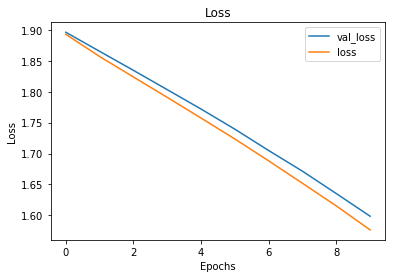

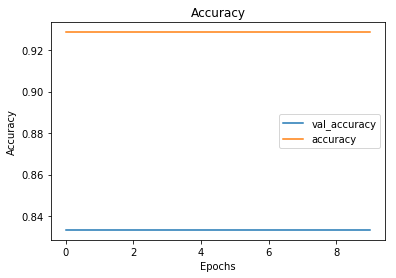

In [101]:
visualize_training_results(history52)

In [102]:
results.append('8 bits 5th model, normalized pixels')
results.append(['acc train',round(history52.history['acc'][-1],3)])
results.append(['acc valid',round(history52.history['val_acc'][-1],3)])
results.append(['loss train',round(history52.history['loss'][-1],3)])
results.append(['loss valid',round(history52.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686],
 '8 bits fifth model',
 ['acc train', 0.929],
 ['acc valid', 0.92],
 ['loss train', 0.293],
 ['loss valid', 0.289],
 '8 bits fifth model smaller batch on import',
 ['acc train', 1.0],
 ['acc valid', 0.833],
 ['loss train', 0.052],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.929],
 ['acc valid', 0.833],
 ['loss train', 1.577],
 ['loss valid', 1.599]]

#### Increasing Image resolution:

In [103]:
# Directory path
train_data_dir = 'dataskin/Train'
test_data_dir = 'dataskin/Test'
#val_data_dir = 'dataset/validation_set'

# Get all the data in the directory data/validation (118 images), and reshape them
test_gen= ImageDataGenerator().flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=118)

# Get all the data in the directory data/train (2239 images), and reshape them
train_gen = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=2239)

# Create the datasets
train_img, train_lab = next(train_gen)
test_img, test_lab = next(test_gen)
#normalizing again
train_img /= 255.
test_img /= 255.

Found 118 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.


In [104]:
train_y = np.reshape(train_lab[:,0], (2239,1))
test_y = np.reshape(test_lab[:,0], (118,1))

In [105]:
model6 = models.Sequential()
model6.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(64, 64, 3)))
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Flatten())
#model5.add(layers.Dense(3, activation='relu'))
model6.add(layers.Dense(9, activation='softmax'))

model6.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [106]:
history6b = model6.fit(train_img,
                    train_y,
                    epochs=10,
                    batch_size=10, validation_split=0.3)

Epoch 1/10
157/157 [==============================] - 2s 13ms/step - loss: 0.2837 - acc: 0.9330 - val_loss: 0.1722 - val_acc: 0.9568
Epoch 2/10
157/157 [==============================] - 2s 13ms/step - loss: 0.2282 - acc: 0.9419 - val_loss: 0.1836 - val_acc: 0.9568
Epoch 3/10
157/157 [==============================] - 2s 12ms/step - loss: 0.2203 - acc: 0.9445 - val_loss: 0.1907 - val_acc: 0.9568
Epoch 4/10
157/157 [==============================] - 2s 12ms/step - loss: 0.2046 - acc: 0.9458 - val_loss: 0.1815 - val_acc: 0.9554
Epoch 5/10
157/157 [==============================] - 2s 15ms/step - loss: 0.1885 - acc: 0.9464 - val_loss: 0.1714 - val_acc: 0.9568
Epoch 6/10
157/157 [==============================] - 2s 12ms/step - loss: 0.1884 - acc: 0.9458 - val_loss: 0.1714 - val_acc: 0.9568
Epoch 7/10
157/157 [==============================] - 2s 13ms/step - loss: 0.1822 - acc: 0.9458 - val_loss: 0.1705 - val_acc: 0.9568
Epoch 8/10
157/157 [==============================] - 2s 12ms/step - 

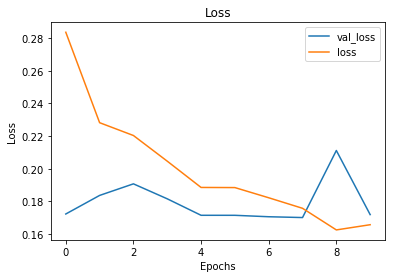

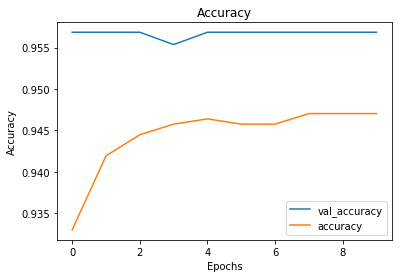

In [107]:
visualize_training_results(history6b)

In [108]:
results.append('64 bits 6th model, same as last one')
results.append(['acc train',round(history6b.history['acc'][-1],3)])
results.append(['acc valid',round(history6b.history['val_acc'][-1],3)])
results.append(['loss train',round(history6b.history['loss'][-1],3)])
results.append(['loss valid',round(history6b.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686],
 '8 bits fifth model',
 ['acc train', 0.929],
 ['acc valid', 0.92],
 ['loss train', 0.293],
 ['loss valid', 0.289],
 '8 bits fifth model smaller batch on import',
 ['acc train', 1.0],
 ['acc valid', 0.833],
 ['loss train', 0.052],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.929],
 ['acc valid', 0.833],
 ['loss train', 1.577],
 ['loss valid', 1.599],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid

#### Increasing number of epochs:

In [109]:
history7 = model6.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=10, validation_split=0.3)

Epoch 1/30
157/157 [==============================] - 2s 12ms/step - loss: 0.1597 - acc: 0.9489 - val_loss: 0.1741 - val_acc: 0.9568
Epoch 2/30
157/157 [==============================] - 2s 12ms/step - loss: 0.1579 - acc: 0.9502 - val_loss: 0.2034 - val_acc: 0.9479
Epoch 3/30
157/157 [==============================] - 2s 12ms/step - loss: 0.1521 - acc: 0.9534 - val_loss: 0.1851 - val_acc: 0.9464
Epoch 4/30
157/157 [==============================] - 2s 11ms/step - loss: 0.1490 - acc: 0.9477 - val_loss: 0.1778 - val_acc: 0.9539
Epoch 5/30
157/157 [==============================] - 2s 11ms/step - loss: 0.1483 - acc: 0.9496 - val_loss: 0.1809 - val_acc: 0.9568
Epoch 6/30
157/157 [==============================] - 2s 12ms/step - loss: 0.1423 - acc: 0.9521 - val_loss: 0.2360 - val_acc: 0.9256
Epoch 7/30
157/157 [==============================] - 2s 12ms/step - loss: 0.1440 - acc: 0.9483 - val_loss: 0.1812 - val_acc: 0.9539
Epoch 8/30
157/157 [==============================] - 2s 12ms/step - 

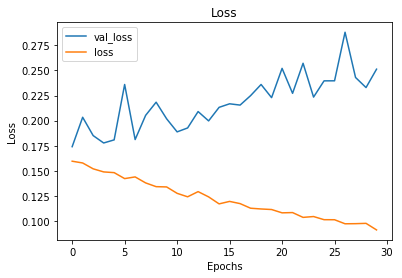

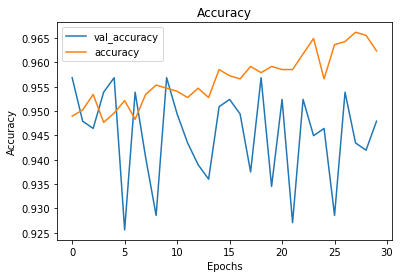

In [110]:
visualize_training_results(history7)

In [111]:
results.append('64 bits 6th model, 30 epochs')
results.append(['acc train',round(history7.history['acc'][-1],3)])
results.append(['acc valid',round(history7.history['val_acc'][-1],3)])
results.append(['loss train',round(history7.history['loss'][-1],3)])
results.append(['loss valid',round(history7.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686],
 '8 bits fifth model',
 ['acc train', 0.929],
 ['acc valid', 0.92],
 ['loss train', 0.293],
 ['loss valid', 0.289],
 '8 bits fifth model smaller batch on import',
 ['acc train', 1.0],
 ['acc valid', 0.833],
 ['loss train', 0.052],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.929],
 ['acc valid', 0.833],
 ['loss train', 1.577],
 ['loss valid', 1.599],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid

#### Adding more layers:

In [112]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(10, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [113]:
history8 = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=10, validation_split=0.3)

Epoch 1/30
157/157 [==============================] - 5s 27ms/step - loss: 0.2968 - acc: 0.9387 - val_loss: 0.1940 - val_acc: 0.9568
Epoch 2/30
157/157 [==============================] - 4s 26ms/step - loss: 0.2403 - acc: 0.9458 - val_loss: 0.1786 - val_acc: 0.9568
Epoch 3/30
157/157 [==============================] - 5s 29ms/step - loss: 0.2274 - acc: 0.9458 - val_loss: 0.2346 - val_acc: 0.9568
Epoch 4/30
157/157 [==============================] - 4s 27ms/step - loss: 0.2190 - acc: 0.9458 - val_loss: 0.2071 - val_acc: 0.9568
Epoch 5/30
157/157 [==============================] - 4s 27ms/step - loss: 0.2202 - acc: 0.9458 - val_loss: 0.1709 - val_acc: 0.9568
Epoch 6/30
157/157 [==============================] - 4s 27ms/step - loss: 0.2104 - acc: 0.9458 - val_loss: 0.1941 - val_acc: 0.9568
Epoch 7/30
157/157 [==============================] - 4s 26ms/step - loss: 0.2082 - acc: 0.9458 - val_loss: 0.1736 - val_acc: 0.9568
Epoch 8/30
157/157 [==============================] - 4s 26ms/step - 

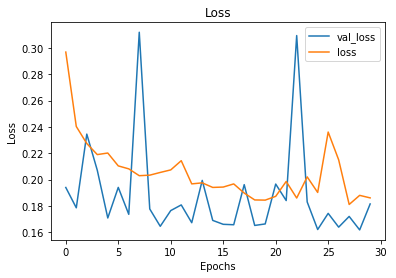

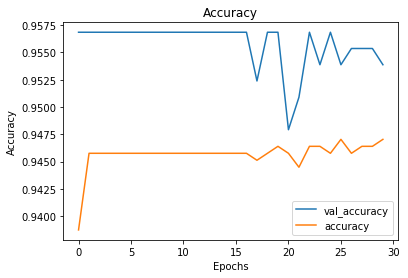

In [114]:
visualize_training_results(history8)

In [115]:
results.append('64 bits 6th model, 30 epochs, more layers')
results.append(['acc train',round(history8.history['acc'][-1],3)])
results.append(['acc valid',round(history8.history['val_acc'][-1],3)])
results.append(['loss train',round(history8.history['loss'][-1],3)])
results.append(['loss valid',round(history8.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686],
 '8 bits fifth model',
 ['acc train', 0.929],
 ['acc valid', 0.92],
 ['loss train', 0.293],
 ['loss valid', 0.289],
 '8 bits fifth model smaller batch on import',
 ['acc train', 1.0],
 ['acc valid', 0.833],
 ['loss train', 0.052],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.929],
 ['acc valid', 0.833],
 ['loss train', 1.577],
 ['loss valid', 1.599],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid

#### Increase the batch size:

In [116]:
history9 = model.fit(train_img,
                    train_y,
                    epochs=30,
                    batch_size=50, validation_split=0.3)

Epoch 1/30
32/32 [==============================] - 3s 100ms/step - loss: 0.1580 - acc: 0.9464 - val_loss: 0.1801 - val_acc: 0.9568
Epoch 2/30
32/32 [==============================] - 3s 99ms/step - loss: 0.1603 - acc: 0.9483 - val_loss: 0.1785 - val_acc: 0.9509
Epoch 3/30
32/32 [==============================] - 3s 102ms/step - loss: 0.1524 - acc: 0.9496 - val_loss: 0.2056 - val_acc: 0.9315
Epoch 4/30
32/32 [==============================] - 3s 99ms/step - loss: 0.1664 - acc: 0.9502 - val_loss: 0.1802 - val_acc: 0.9494
Epoch 5/30
32/32 [==============================] - 3s 98ms/step - loss: 0.1454 - acc: 0.9528 - val_loss: 0.1998 - val_acc: 0.9390
Epoch 6/30
32/32 [==============================] - 3s 99ms/step - loss: 0.1551 - acc: 0.9496 - val_loss: 0.1938 - val_acc: 0.9449
Epoch 7/30
32/32 [==============================] - 3s 99ms/step - loss: 0.1487 - acc: 0.9509 - val_loss: 0.1959 - val_acc: 0.9539
Epoch 8/30
32/32 [==============================] - 3s 99ms/step - loss: 0.1484 -

In [117]:
y_hat_train=model.predict(train_img)
y_hat_test=model.predict(test_img)

In [118]:
y_hat_train

array([[9.9998975e-01, 1.0303448e-05, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.5396799e-01, 4.6031952e-02, 2.5872169e-14, ..., 2.0827368e-14,
        2.9064235e-14, 7.8202063e-15],
       [9.3315393e-01, 6.6846028e-02, 2.0849260e-12, ..., 1.7004665e-12,
        2.1444884e-12, 1.5309169e-12],
       ...,
       [1.0000000e+00, 2.3849507e-08, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.8870212e-10, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [9.9999857e-01, 1.4355236e-06, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

Clearly here I have to round to get the actual prediction for the class.

In [119]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [120]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

pr_train=precision_score(train_labels, train_labels, average=None)
#rec_train=recall_score(train_labels, y_hat_train)
#acc_train=accuracy_score(train_labels, y_hat_train)
#f1_train=f1_score(train_labels, y_hat_train)

#pr_test=precision_score(test_labels, y_hat_test)
#rec_test=recall_score(test_labels, y_hat_test)
#acc_test=accuracy_score(test_labels, y_hat_test)
#f1_test=f1_score(test_labels, y_hat_test)
pr_train
#print("Train: \nprecision", pr_train,"\nrecall:", rec_train, '\naccuracy:', acc_train, '\nf1 score:', f1_train,'\n')
#print("Test: \nprecision", pr_test,"\nrecall:", rec_test, '\naccuracy:', acc_test, '\nf1 score:', f1_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

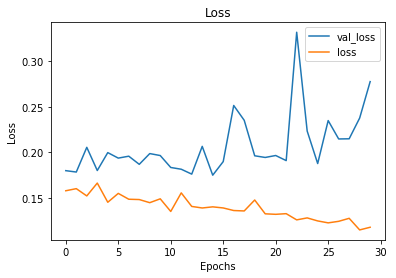

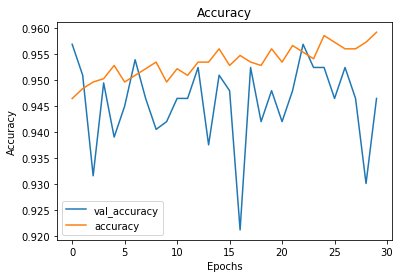

In [121]:
visualize_training_results(history9)

In [122]:
results.append('64 bits 6th model, increased batch size')
results.append(['acc train',round(history9.history['acc'][-1],3)])
results.append(['acc valid',round(history9.history['val_acc'][-1],3)])
results.append(['loss train',round(history9.history['loss'][-1],3)])
results.append(['loss valid',round(history9.history['val_loss'][-1],3)])
results

['32 bits first model',
 ['acc train', 0.965],
 ['acc valid', 0.929],
 ['loss train', 0.187],
 ['loss valid', 0.734],
 '32 bits second model, larger batch',
 ['acc train', 0.968],
 ['acc valid', 0.895],
 ['loss train', 0.088],
 ['loss valid', 0.669],
 '32 bits third model, less neurons in last layer',
 ['acc train', 0.95],
 ['acc valid', 0.946],
 ['loss train', 0.185],
 ['loss valid', 0.204],
 '32 bits fourth model, less neurons overall',
 ['acc train', 0.949],
 ['acc valid', 0.942],
 ['loss train', 0.356],
 ['loss valid', 0.686],
 '8 bits fifth model',
 ['acc train', 0.929],
 ['acc valid', 0.92],
 ['loss train', 0.293],
 ['loss valid', 0.289],
 '8 bits fifth model smaller batch on import',
 ['acc train', 1.0],
 ['acc valid', 0.833],
 ['loss train', 0.052],
 ['loss valid', 0.38],
 '8 bits 5th model, normalized pixels',
 ['acc train', 0.929],
 ['acc valid', 0.833],
 ['loss train', 1.577],
 ['loss valid', 1.599],
 '64 bits 6th model, same as last one',
 ['acc train', 0.947],
 ['acc valid

#### Changing activation functions and optimizations:
Some of the options for activation functions are:
<br>relu
<br>swish
<br>softmax
<br>leaky relu
<br>sigmoid

<br>for optimizers:
<br>adam, sgd, 
<br>with optimizer I can also tweak the learning rate

<br>for loss functions:
categorical_crossentropy, 


In [123]:
model = models.Sequential()
model.add(layers.Conv2D(10, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(10, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['acc'])

maybe Even make a graph with this learning curve.
Can do it within the pipeline?

In [124]:

#sklearn.preprocessing.minmax_scale(X, feature_range=(0, 1), axis=0, copy=True)

NameError: name 'sklearn' is not defined